In [1]:
import anndata
import scanpy as sc
import scrublet as scr
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

"*In detail, the cells with (i) total UMI counts less than 1000, (ii) detected gene numbers less than 500, or (iii) mitochondrial genes percentage more than 20 were filtered. Then we performed normalization, feature selection, scaling, PCA dimension reduction, clustering and UMAP dimension reduction following the standard Seurat pipeline. We performed doublet identification using function doubletCells of R package scran for each sample. However, no cell clusters were detected as significant doublets.*

*We inferred cell cycle states for each cell using function CellCycleScoring of R package Seruat. The gene expression scores of given gene set were calculated using function addModuleScore of Seurat. The differentially expressed genes between cell groups were calculated using function FindMarkers of Seurat.*"

STEPS:

    1.Load data
    2.Quality control -> filter by UMI counts, detected genes, and mt-genes. 
    3.Data normalization
    4.Doublet identification -> Seurat doubletCells. Cells that contain mixed transcriptomes from two or more cells.
    5.Feature selection
    6.Scaling
    7.PCA
    8.Clustering 
    9.UMAP
    
    Others: cell cycle states (CellCycleScoring), gene expression scores (addModuleScore), expressed genes between cell groups (FindMarkers) 

### 1.Load data

In [2]:
""" 1.Load data: Create a count matrix with all samples (row = conteos, columns = cells ) 
--------------------------------------------------------------------------------------------
#usedSample <- c("ADSC","S1D4", "S1D8","S2D4", "S2D8", "S2D12", "S2D16")
#dataList <- map(str_c("data/hADSC_scRNA/", usedSample), Read10X)
#names(dataList) <- usedSample
#dataList <- imap(dataList, ~ {set_colnames(.x, str_c(.y, "_", colnames(.x)))})
#map_int(dataList, ncol)
#countData <- do.call(cbind, dataList)
#allSo <- CreateSeuratObject(countData)
#saveRDS(allSo, "middata/hADSC_scRNA/allSo_raw.rds") 
--------------------------------------------------------------------------------------------
"""
# Load AnnData objects
adata = anndata.read_h5ad("./data/adata.h5ad.gz")
print(f"Data loaded: {adata.shape} cells x genes")
adata_somatic = anndata.read_h5ad("./data/hADSC-1013/hADSC1013_adata.h5ad.gz")
print(f"Somatic cells data: {adata_somatic.shape} cells x genes")
adata_plastic = anndata.read_h5ad("./data/hADSC-1013_SIID16/hADSC1013_SIID16_adata.h5ad.gz")
print(f"Intermediate plastic state cells data: {adata_plastic.shape} cells x genes")


Data loaded: (10328, 32738) cells x genes
Somatic cells data: (5404, 32738) cells x genes
Intermediate plastic state cells data: (4924, 32738) cells x genes


In [3]:
adata

AnnData object with n_obs × n_vars = 10328 × 32738
    obs: 'reprogramming_type', 'reprogramming_stage', 'cell_state', 'cell_type', 'cell_line'

### 2.Quality control

#### 2.1 QC metrics

QC metrics are computed in scRNA-seq data to detect broken, empty or multiple (mix of broken) cells. I mean, cells with low quality. 

Observation level metrics are: 

* total_{var_type}_by_{expr_type}: E.g. “total_genes_by_counts”. Number of genes with positive counts in a cell(expressed).
* total_{expr_type}: E.g. “total_counts”. Total number of counts for a cell.
* pct_{expr_type}_in_top_{n}_{var_type}: E.g. “pct_counts_in_top_50_genes”. Cumulative percentage of counts for 50 most expressed genes in a cell.
* total_{expr_type}_{qc_var}: E.g. “total_counts_mito”. Total number of counts for variables in qc_vars.
* pct_{expr_type}_{qc_var}: E.g. “pct_counts_mito”. Proportion of total counts for a cell which are mitochondrial.

Variable level metrics include:

* total_{expr_type}: E.g. “total_counts”. Sum of counts for a gene.
* n_genes_by_{expr_type}: E.g. “n_genes_by_counts”. The number of genes with at least 1 count in a cell. Calculated for all cells.
* mean_{expr_type}: E.g. “mean_counts”. Mean expression over all cells.
* n_cells_by_{expr_type}: E.g. “n_cells_by_counts”. Number of cells this expression is measured in.
* pct_dropout_by_{expr_type}: E.g. “pct_dropout_by_counts”. Percentage of cells this feature does not appear in.

#### 2.2 Analysis

Number of mithocondrial genes: 13


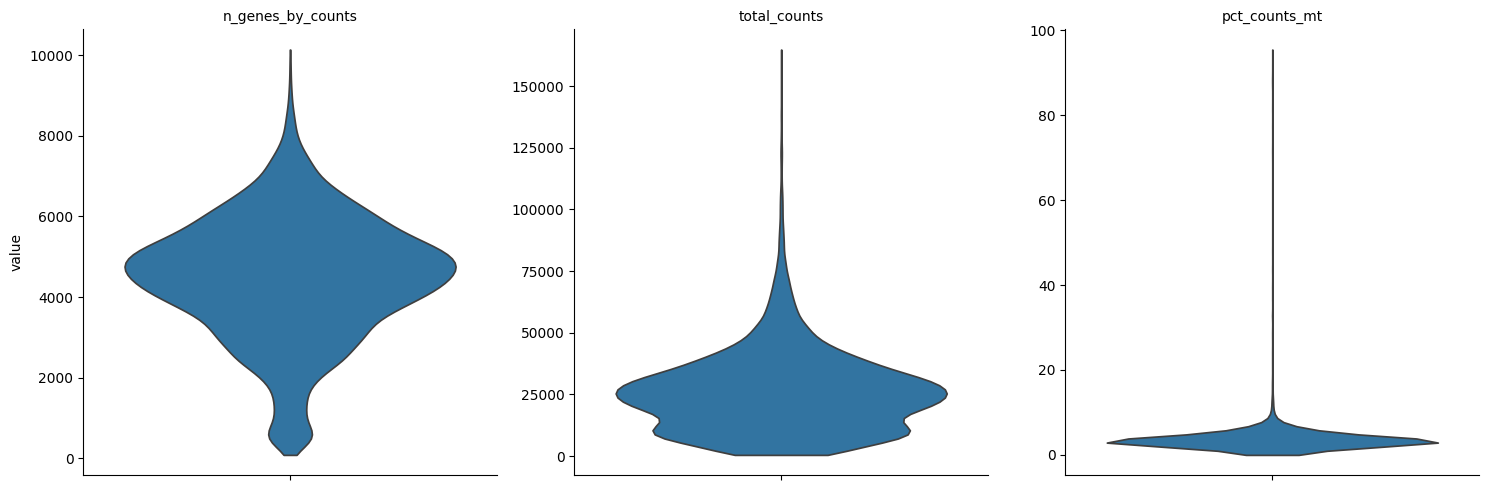

In [4]:
# mitochondrial genes, "MT-" for human
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],inplace=True, log1p=True)
print(f"Number of mithocondrial genes: {Counter(adata.var.mt).get(True,0)}")

# Violin plot to check MT genes and counts -> BEFORE FILTERING
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    stripplot=False
)

*n_genes_by_counts*
1. Description: The first plot shows the distribution of the number of genes expressed per cell (n_genes_by_counts).
2. Interpretation:
    - Most cells have between approximately 1,000 and 6,000 expressed genes (high density of cells around 5,000 expressed genes)
    - There is a notable decrease in the number of cells with more than 6,000 expressed genes.
    - There is a small fraction of cells with fewer than 1,000 expressed genes, which might indicate low-quality or damaged cells.

*total_counts*
1. Description: The second plot shows the distribution of the total RNA counts (reads) per cell (total_counts).
2. Interpretation:
    - Most cells have between approximately 25,000 and 100,000 counts.
    - There are some cells with more than 100,000 counts, although they are less common.
    - The shape of this plot also suggests high variability in the total counts between cells, with a long tail extending to higher values.

*pct_counts_mt*
1. Description: The third plot shows the distribution of the percentage of mitochondrial counts per cell (pct_counts_mt).
2. Interpretation:
    - A high percentage of mitochondrial counts can indicate stressed or damaged cells, as cells in these conditions tend to release more mitochondrial RNA.
    - Most cells have a very low percentage of mitochondrial counts, generally below 20%.



**General Conclusion**

These distributions are useful for deciding filtering thresholds and ensuring that only high-quality cells are used in subsequent analyses.

1. Cell Quality: Most cells have a reasonable number of expressed genes and total counts, which indicates good quality.
2. Stressed or Damaged Cells: The presence of some cells with high percentages of mitochondrial counts and/or low numbers of expressed genes might signal the need for additional filtering to remove low-quality or damaged cells before proceeding with more detailed analyses.








227 samples have been deleted. 
Data shape after filtering: (10101, 32738)


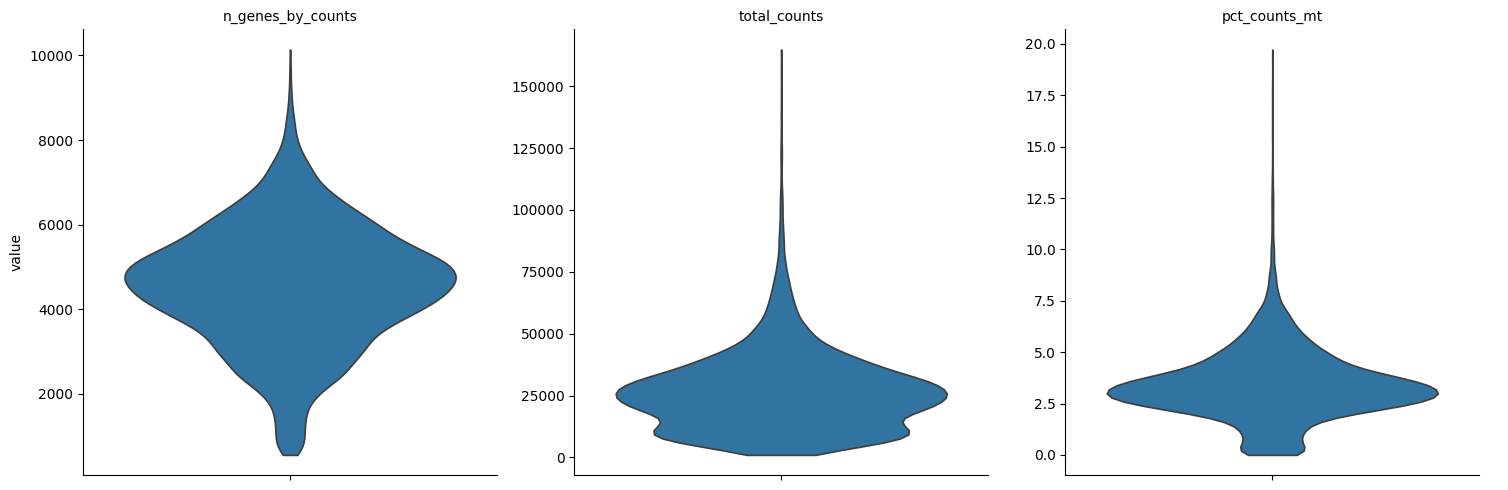

In [7]:
""" 2.Quality control: samples that meet the criteria are removed 
    (i) Total UMI counts less than 1000 -> Represent the absolute number of observed transcripts (total count of RNA)
    (ii) Detected gene numbers less than 500 (expressed)
    (iii) Mitochondrial genes percentage more than 20 (% genic expression)-> because it can be dead and damaged cells

--------------------------------------------------------------------------------------------
#allSo <- readRDS("middata/hADSC_scRNA/allSo_raw.rds")
#allSo$sample <- str_extract(colnames(allSo), ".*_") %>% str_remove("_$")
#table(allSo$sample)
#mtGene <- rownames(allSo) %>% str_subset("^MT-")
#allSo$mt <- PercentageFeatureSet(allSo, features = mtGene)
#allSo <- allSo[, allSo$nFeature_RNA > 500 & allSo$nCount_RNA > 1000 & allSo$mt < 20]
--------------------------------------------------------------------------------------------
"""

adata_filtered = adata.copy()
sc.pp.filter_cells(adata_filtered, min_genes=500)
sc.pp.filter_cells(adata_filtered, min_counts=1000)
adata_filtered = adata_filtered[adata_filtered.obs.pct_counts_mt < 20, :]
print(f"""{adata.shape[0] - adata_filtered.shape[0]} samples have been deleted. 
Data shape after filtering: {adata_filtered.shape}""")

# Violin plot to check MT genes and counts -> AFTER FILTERING
sc.pl.violin(
    adata_filtered,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    stripplot=False
)

*n_genes_by_counts*
1. Description: The first plot shows the distribution of the number of genes expressed per cell (n_genes_by_counts).
2. Interpretation:
    - The majority of cells have between approximately 2,000 and 8,000 expressed genes.
    - The distribution has a peak around 5,000 expressed genes, indicating a high density of cells at this level.
    - The tail extending beyond 8,000 expressed genes is less pronounced, and there are very few cells with fewer than 2,000 expressed genes, suggesting that low-quality cells with very few expressed genes have been filtered out.


*total_counts*
1. Description: The second plot shows the distribution of the total RNA counts (reads) per cell (total_counts).
2. Interpretation:
    - Most cells have between approximately 25,000 and 100,000 total counts.
    - There are fewer cells with counts significantly higher than 100,000, and the cells with very low total counts have been largely removed, indicating that the filtering process has effectively removed cells with abnormal total counts.

*pct_counts_mt*
1. Description: The third plot shows the distribution of the percentage of mitochondrial counts per cell (pct_counts_mt).
2. Interpretation:
    - The majority of cells have a mitochondrial count percentage between 0% and 7.5%.
    - The distribution peaks around 2.5%, indicating a high density of cells with this percentage of mitochondrial counts.
    - The tail extends up to about 20%, but cells with higher percentages of mitochondrial counts (indicative of stress or damage) are much less frequent, suggesting effective filtering of cells with excessively high mitochondrial RNA content.


**General Conclusion**
These plots show that the dataset has been effectively filtered to improve quality:

1. n_genes_by_counts: Low-quality cells with very few expressed genes have been removed.
2. total_counts: Cells with abnormally low or high total RNA counts have been filtered out.
3. pct_counts_mt: Cells with high percentages of mitochondrial counts, which may indicate stress or damage, have been largely removed.

### 3.Normalization

Normalize the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000), and log-transforms the result.

In [8]:
""" 3.Data normalization: 
    “LogNormalize”: Feature counts for each cell are divided by the total counts for that cell and multiplied 
    by the scale.factor (10000 in this case). This is then natural-log transformed using log1p.

--------------------------------------------------------------------------------------------
#allSo %<>% NormalizeData 
--------------------------------------------------------------------------------------------
"""

# Normalize data so that the total count per cell is equal to 10,000 (scale factor)
normalized_data = adata_filtered.copy()
sc.pp.normalize_total(normalized_data, target_sum=1e4)
# log n+1 transformation
sc.pp.log1p(normalized_data)

### 4.Doublet detection

#### 4.1 Doublet cells

Doublet cell identification refers to the process of detecting and filtering out "doublets." A doublet occurs when two cells are mistakenly captured and sequenced as a single cell. This can lead to misleading results because the expression profile of a doublet will contain RNA from both cells, potentially distorting the true biological signal.

*Impact of Doublets*
1. False Expression Patterns: Doublets can artificially inflate the number of detected genes and total counts, as they represent the combined transcriptomes of two cells.
2. Misleading Biological Interpretation: They can lead to incorrect conclusions about cell types, states, and trajectories because the mixed signals can appear as novel or hybrid cell types.

*Mitigating Doublets*
1. Optimal Cell Loading: Adjusting the cell concentration during the loading process to minimize the chance of multiple cells being captured together.
2. Post-capture Analysis: Using doublet detection tools and stringent filtering criteria during the data analysis phase.

*Identifying Doublets*

Several strategies and computational tools are used to identify and remove doublets from scRNA-seq datasets:

1. Statistical Methods: Algorithms like Scrublet, DoubletFinder, and DoubletDetection use statistical models to predict the likelihood of each cell being a doublet based on the transcriptome profile.

    - Scrublet: Simulates doublets by adding the profiles of two random cells and then identifies real cells with similar profiles. https://doi.org/10.1016/j.cels.2018.11.005
    - DoubletFinder: Uses pre-existing clustering information to identify and score potential doublets. https://doi.org/10.1016/j.cels.2019.03.003
    - DoubletDetection: Utilizes a machine learning approach to classify doublets based on features derived from the data.
    - Expression Metrics: Cells with unusually high numbers of detected genes or total counts compared to the majority of cells in the dataset are flagged as potential doublets. These metrics can be visualized using violin plots, histograms, or scatter plots.

2. Marker Gene Expression: Checking for simultaneous expression of marker genes from different, mutually exclusive cell types can indicate doublets. For example, if a cell expresses high levels of both neuronal and immune cell markers, it might be a doublet.

3. Barcoding Techniques: Some newer technologies use genetic or chemical barcoding to label individual cells, making it easier to detect and exclude doublets based on barcode collisions.


#### 4.2 Analysis

We are goint to use Scrublet (doubletCells in R). 

In [7]:
""" 4.Doublet identification: 
        - Identify variable features and use it to detect double cells.
        - doubletCells in R: This function simulates doublets by adding the count vectors for two randomly chosen cells in x. 
        For each original cell, we compute the density of neighboring simulated doublets and compare it to the density of 
        neighboring original cells. Genuine doublets should have a high density of simulated doublets relative to the density 
        of its neighbourhood. Thus, the doublet score for each cell is defined as the ratio of densities of simulated doublets
        to the (squared) density of the original cells.
        Densities are calculated in low-dimensional space after a PCA on the log-normalized expression matrix of x. 
        Simulated doublets are projected into the low-dimensional space using the rotation vectors computed from the original
        cells. A tricube kernel is used to compute the density around each cell. The bandwidth of the kernel is set to the
        median distance to the k nearest neighbour across all cells.
        
        - Applies a log transformation to the doublet cell counts (dblDen) for each sample (help in visualizing and analyzing
        the distribution of doublet cell counts)

-------------------------------------------------------------------------------------------
#  Splits the allSo object into a list of objects based on the "sample" column
soList <- SplitObject(allSo, "sample") 

# Finds the variable features for each sample in the list
soList <- map(soList, FindVariableFeatures)

# Creates a list of SingleCellExperiment objects with the count data and log-transformed data
SCElist <- map(soList, ~ SingleCellExperiment(assays = list(counts = .x[["RNA"]]@counts, logcounts = .x[["RNA"]]@data)))

# Extracts the variable features for each sample
varGeneList <- map(soList, VariableFeatures)

# Calculates the doublet densities for each SingleCellExperiment object using the variable features 
dblDen <- map2(SCElist, varGeneList, ~ doubletCells(.x, subset.row = intersect(rownames(.x), .y), d = 20))
    # d = 20 -> Number of components to retain after the PCA.
    # --- DEFAULT PARAMETERS ----
    # k = 50 -> Number of nearest neighbours to use to determine the bandwidth for density calculations
    # BNPARAM = KmknnParam() -> Nearest neighbor algorithm (euclidean distance)
    # BSPARAM = bsparam() -> Algorithm to use for PCA
    # BPPARAM = SerialParam() ->  Neighbour searches parallelized or not
    # niters = max(10000, ncol(x)) -> How many simulated doublets should be generated
    # block = 10000 -> Controlling the rate of doublet generation, to keep memory usage low
    
# Takes the base 10 logarithm of the doublet densities plus 1
dblDen <- map(dblDen, ~ log10(.x + 1))
allSo$dbl <- unlist(dblDen) %>% unname
-------------------------------------------------------------------------------------------
"""
# Scrublet -> Predicts cell doublets using a nearest-neighbor classifier of observed transcriptomes
# https://doi.org/10.1016/j.cels.2018.11.005
# 1. Doublet simulation
# 2. Normalization, gene filtering, rescaling, PCA
# 3. Doublet score calculation
# 4. Doublet score threshold detection and doublet calling

## 1.Same approach using Highly Variable Features/Sample ------------------------
# Identifica genes variables por muestra, no sobre la matriz de conteos completa

dbl_scores_list = []
samples_without_HVG = []

for idx, _ in enumerate(normalized_data.obs_names):
    # Sample
    adata_sample = normalized_data[idx].copy()
    # 1. Find Highly Variable Features in sample
    try: 
        HVG = True
        sc.pp.highly_variable_genes(
            adata_sample,
            flavor="seurat",
            # n_top_genes=2000, # limitan el número a de genes variables a 2000. CHECK THIS!!! 
            span=0.3,
            n_bins=20,
            min_mean=0.1,
            max_mean=8,
            min_disp=1,
            max_disp=float('inf')
        ) 
        print("There are Highly Variable Genes in this sample")
    except ZeroDivisionError: 
        # print("There aren't Highly Variable Genes in this sample.")
        HVG = False
        samples_without_HVG.append(idx)
        adata_sample.var["highly_variable"] = False

    # 2.Perform Doublet detection if there are HGV in sample
    if HVG: 
        print("Performing Doublet detection...")
        scrub = scr.Scrublet(adata_sample[:, adata_sample.var.highly_variable].X, n_neighbors=50)
        doublet_scores, predicted_doublets = scrub.scrub_doublets(n_prin_comps=20)
        print(doublet_scores)
        # Log-transform the doublet scores
        log_doublet_scores = np.log10(doublet_scores + 1)
        # Almacenar las puntuaciones de doublets
        dbl_scores_list.append(log_doublet_scores)
    else:
        # print("Doublet detection is not performed.")
        continue

if dbl_scores_list:
    all_dbl_scores = np.concatenate(dbl_scores_list)
    # Save Doublet scores in Anndata matrix (all)
    adata.obs['dbl'] = all_dbl_scores

print(f"Samples without Highly Variable Genes: {len(samples_without_HVG)}.")
if len(samples_without_HVG) == normalized_data.shape[0]:
    print("Doublets not detected in data. ")

Samples without Highly Variable Genes: 10101.
Doublets not detected in data. 


In this first approach Doublet Detection is performed in separate samples (cells). 
* Pros: Identifying variable genes within each sample independently can better capture the specific biological variability of each sample, which is useful if there are different experimental conditions or biological samples.
* Cons: This may result in a set of variable genes that are not directly comparable between samples, complicating subsequent analysis if the data are combined again.

In this case there are not doublets detected (no highly variable genes per sample -> not double detection).

The second approach is perform Doublet Detection on the entire count matrix. 

* Pros: Variable genes are identified across the entire dataset, considering all cells. This can provide a more robust set of variable genes if the cells are homogeneous or if the samples are comparable.
* Cons: If there is significant variation between samples or conditions, highly variable genes might be dominated by differences between samples rather than true biological differences within the samples.

In this case there are 1 doublet detected. 

Preprocessing...


/home/alopez/3.Aging_and_chemical_reprogramming/env/lib/python3.11/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/home/alopez/3.Aging_and_chemical_reprogramming/env/lib/python3.11/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 50.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 7.3 seconds
Running UMAP...


/home/alopez/3.Aging_and_chemical_reprogramming/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alopez/3.Aging_and_chemical_reprogramming/env/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(<Figure size 800x400 with 3 Axes>,
 array([<Axes: title={'center': 'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <Axes: title={'center': 'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

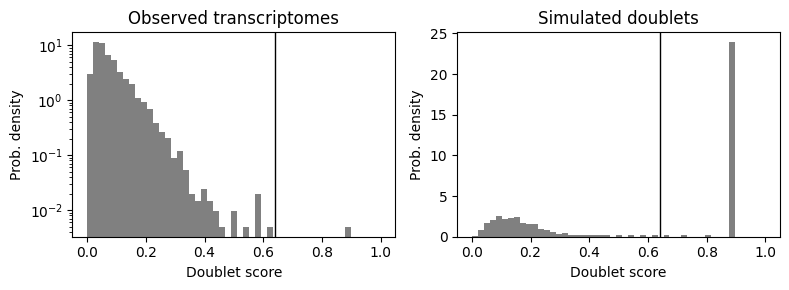

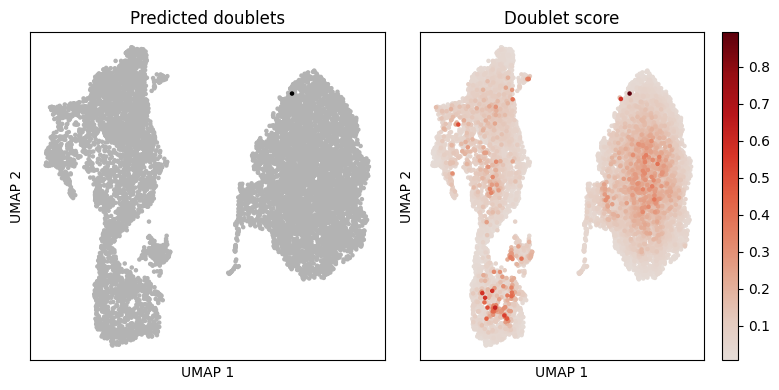

In [8]:
## 2. All samples ----------------------------------------

# Works best if the input is a raw (unnormalized) counts matrix. TODO: debería normalizarse después
# sc.pp.scrublet(normalized_data, n_prin_comps=20, n_neighbors=50)
# sc.pl.scrublet_score_distribution(normalized_data)

normalized_data_copy = normalized_data.copy()
scrub = scr.Scrublet(normalized_data_copy.X, n_neighbors=50)
doublet_scores, predicted_doublets = scrub.scrub_doublets(n_prin_comps=20)
# Distribution of doublets scores for all cells. The doublet scores
# are continuous values that indicate the probability that a cell is a doublet (threshold for separating populations).
# Automatic threshold: this is set automatically by looking for the minimum between the two modes of the doublet_scores_sim_ histogram.
scrub.plot_histogram()

print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True)

### 5.Feature selection

#### 5.1 Highly variable genes

Calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others) because focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

https://doi.org/10.1016/j.cell.2019.05.031

This method models the mean-variance relationship inherent in single-cell data.

"*In each dataset, we next aimed to identify a subset of features (e.g., genes) exhibiting high variability across cells, and therefore represent heterogeneous features to prioritize for downstream analysis. Choosing genes solely based on their log-normalized single-cell variance fails to account for the mean-variance relationship that is inherent to single-cell RNA-seq. Therefore, we first applied a variance-stabilizing transformation to correct for this [Mayer et al., 2018, Hafemeister and Satija, 2019].*
*To learn the mean-variance relationship from the data, we computed the mean and variance of each gene using the unnormalized data (i.e., UMI or counts matrix), and applied log10 -transformation to both. We then fit a curve to predict the variance of each gene as a function of its mean, by calculating a local fitting of polynomials of degree 2 (R function loess, span = 0.3). This global fit provided us with a regularized estimator of variance given the mean of a feature. As such, we could use it to standardize feature counts without removing higher-than-expected variation. Given the expected variances, we performed the transformation zij=xij−x¯iσi.*

*This variance represents a measure of single-cell dispersion after controlling for mean expression, and we use it directly to rank the features. Unless otherwise noted, we selected the 2,000 genes with the highest standardized variance as “highly variable.” This procedure is implemented in the FindVariableFeatures function in Seurat v3 (selection.method = “vst”).*"

#### 5.2 Analysis

/home/alopez/3.Aging_and_chemical_reprogramming/env/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


Number of highly variable genes: 2000


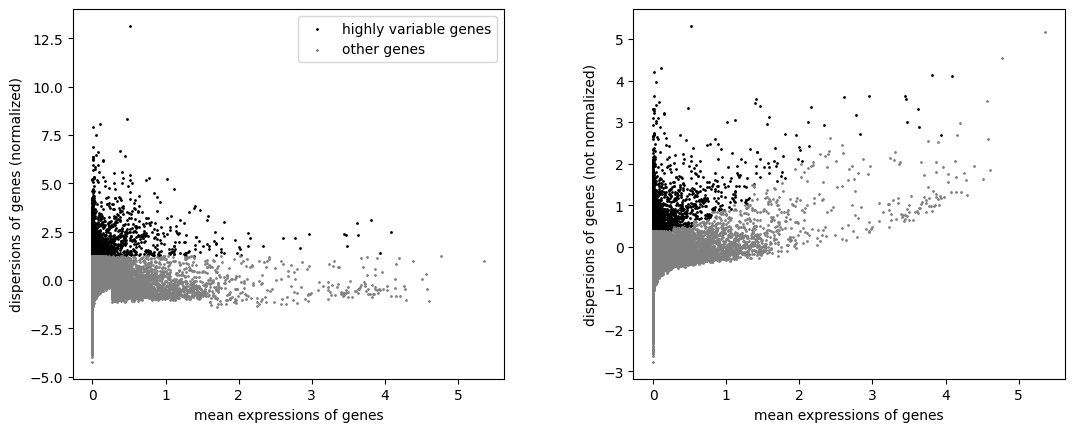

In [9]:
""" 5.Feature selection: Identify features as variables, then use only these genes -> feature selection

    ** FindVariableFeatures(..., method='vst'). 
        # “vst”: First, fits a line to the relationship of log(variance) and log(mean) using local polynomial regression (loess).
        Then standardizes the feature values using the observed mean and expected variance (given by the fitted line). 
        Feature variance is then calculated on the standardized values after clipping to a maximum (see clip.max parameter).

-------------------------------------------------------------------------------------------------
allSo %<>% FindVariableFeatures
# DEFAULT PARAMETERS ------------
# selection.method = "vst" 
# loess.span = 0.3 -> Loess span parameter used when fitting the variance-mean relationship
# clip.max = "auto" -> sets this value to the square root of the number of cells
# mean.function = FastExpMean -> Compute x-axis value (average expression). Default is to take the mean of the detected (i.e. non-zero) values
# dispersion.function = FastLogVMR -> Compute y-axis value (dispersion). Default is to take the standard deviation of all values
# num.bin = 20 -> Total number of bins to use in the scaled analysis
# binning.method = "equal_width" -> Specifies how the bins should be computed. Each bin is of equal width along the x-axis (default)
# nfeatures = 2000 -> number of features to select as top variable features
# mean.cutoff = c(0.1, 8) -> A two-length numeric vector with low- and high-cutoffs for feature means
# dispersion.cutoff = c(1, Inf) -> A two-length numeric vector with low- and high-cutoffs for feature dispersions
-------------------------------------------------------------------------------------------------
"""

# Identify highly variable genes (HVGs) -> Expects logarithmized data
HVG_data = normalized_data.copy()

sc.pp.highly_variable_genes(
        HVG_data,
        flavor="seurat",
        n_top_genes=2000, # limitan el número a de genes variables a 2000
        span=0.3,
        n_bins=20,
        min_mean=0.1,
        max_mean=8,
        min_disp=1,
        max_disp=float('inf')
    ) 

print(f"Number of highly variable genes: {HVG_data.var['highly_variable'].sum()}")
sc.pl.highly_variable_genes(HVG_data)
# Filter expression matrix to include only genes with high variability.
HVG_data = HVG_data[:, HVG_data.var.highly_variable]

### 6.Scaling

Standard pre-processing step prior to dimensional reduction techniques like PCA.

1. Shifts the expression of each gene, so that the mean expression across cells is 0
2. Scales the expression of each gene, so that the variance across cells is 1
3. This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominat

In [10]:
""" 6.Scaling
-------------------------------------------------------------------------------------------------
allSo %<>% ScaleData 
-------------------------------------------------------------------------------------------------
"""

pcHVG_data = HVG_data.copy()
# Max value to return for scaled data. Setting this can help reduce the effects of features that are only expressed in a very small number of cells
sc.pp.scale(pcHVG_data, max_value=10)

### 7.PCA

2000 Highly variable features are used as input. The output is a list of genes with the most positive and negative loadings, representing modules of genes that exhibit either correlation (or anti-correlation) across single-cells in the dataset.

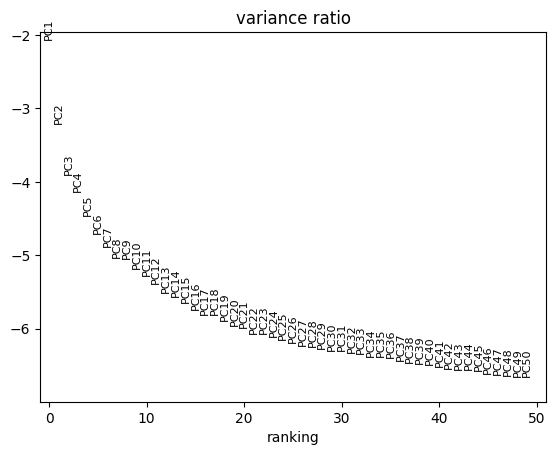

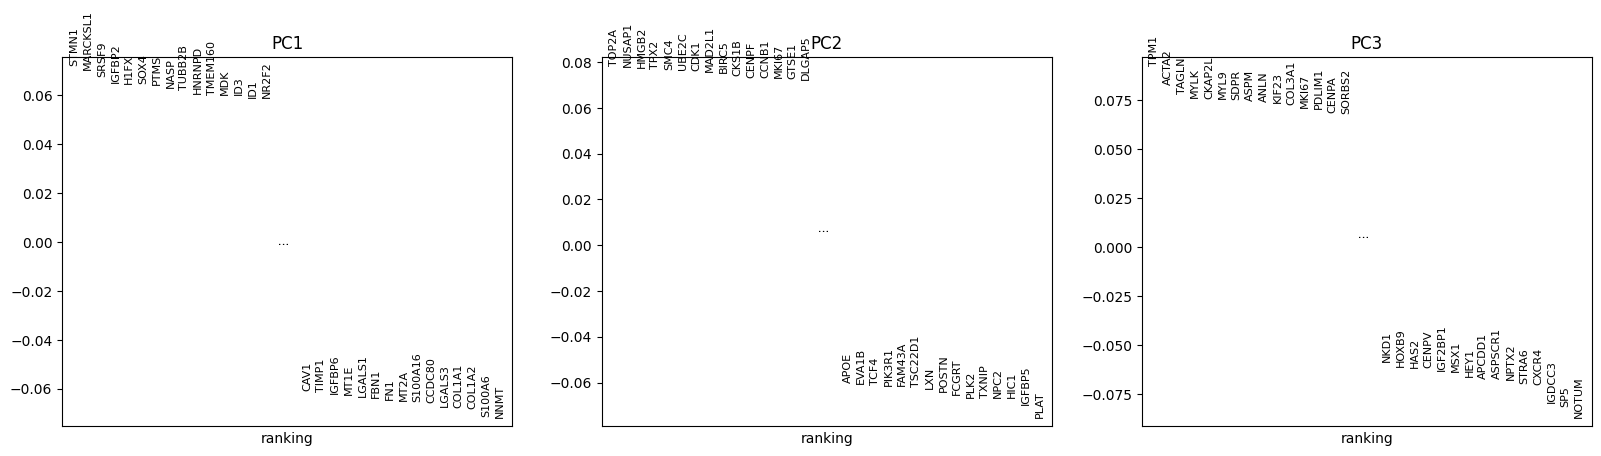

In [11]:
""" 7.PCA: Dimensionality reduction with 50 components. 

-------------------------------------------------------------------------------------------------
%>% RunPCA

# Ranking of principle components based on the percentage of variance explained by each one -> decide nº PC
allSo %>% ElbowPlot(ndims = 50)
-------------------------------------------------------------------------------------------------
"""
# scikit-learn implementation
sc.tl.pca(pcHVG_data, n_comps=50, svd_solver='randomized')
# Inspect the contribution of single PCs to the total variance in the data
sc.pl.pca_variance_ratio(pcHVG_data, log=True, n_pcs=50)
# Rank genes according to contributions to PC
sc.pl.pca_loadings(pcHVG_data)

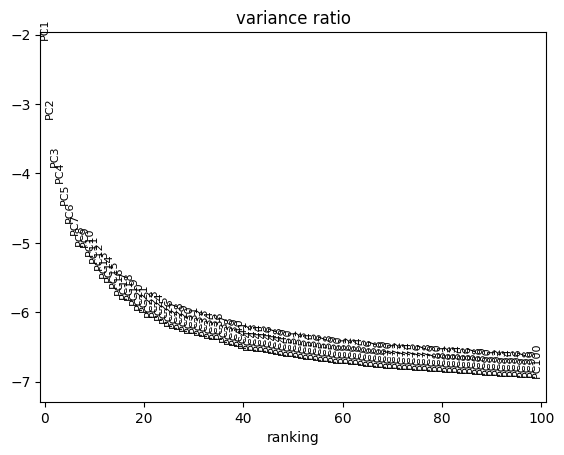

In [12]:
# Try with 100 components to see Elbow
pcHVG_data_copy = pcHVG_data.copy()
sc.tl.pca(pcHVG_data_copy, n_comps=100, svd_solver='randomized')
# Inspect the contribution of single PCs to the total variance in the data
sc.pl.pca_variance_ratio(pcHVG_data_copy, log=True, n_pcs=100)

### 8.Clustering

Graph-based clustering approach. Embed cells in a graph structure with edges drawn between cells with similar feature expression patterns, and then attempt to partition this graph into highly interconnected ‘quasi-cliques’ or ‘communities’.

Constructs a Shared Nearest Neighbor (SNN) Graph for a given dataset. We first determine the k-nearest neighbors of each cell (based on the euclidean distance + ANNOY https://github.com/spotify/annoy in PCA space, 20PCs). We use this knn graph to construct the SNN graph by calculating the neighborhood overlap (Jaccard index) between every cell and its k.param nearest neighbors.

To cluster the cells, we next apply modularity optimization techniques such as the Louvain algorithm (default) with the goal of optimizing the standard modularity function. The FindClusters() function implements this procedure, and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters. 

Steps: 

1. Construction of a k-nearest neighbor graph (kNN), where each cell is a node in the graph with edges to its k nearest neighbors.
2. Construction of a Shared Nearest Neighbor (SNN) graph from the kNN graph using the method of [Xu and Su, 2015]. Briefly, in the SNN graph each cell is again a node, but two cells are only connected by an edge if they share a nearest neighbor in the kNN graph. Neighbors of each cell in the kNN graph are ranked from 1 (the same cell, because each cell is its own closest neighbor) to k (the most distant neighbor). Edges in the SNN graph are weighted according to the best of the average ranks of their shared neighbors. Edges connecting cells that share close nearest neighbors are weighted higher than edges connecting cells that only share distant nearest neighbors.
3. Application of Louvain community detection to the weighted SNN graph [Traag et al., 2019].

#### 8.1 SNN

https://doi.org/10.1093/bioinformatics/btv088

*We first compute a similarity matrix using Euclidean distance (other suitable measures can also be used instead) between pairs of data points (e.g. a point is a cell and the distance between points is calculated using the vectors of gene expression levels in the cells). Next, for each data point xi, we list the k-nearest-neighbors (KNN) using the similarity matrix, with xi itself as the first entry in the list. To construct an SNN graph, for a pair of points xi and xj, we assign an edge e(xi, xj) only if xi and xj have at least one shared KNN. The weight of the edge e(xi, xj) is defined as the difference between k and the highest averaged ranking of the common KNN.*

*Therefore, this SNN graph captures the similarity between two nodes in terms of their connectivity in the neighborhood. In other words, unlike the primary similarity, in our measure, the similarity between two nodes needs to be confirmed by their closeness to other nodes (common nearest neighbors). The rationale behind SNN is that the ranking of nodes is usually still meaningful in high-dimensional space though the primary similarity might not (Houle et al., 2010). The ranking of shared neighbors of two nodes in a genuine cluster is expected to be high, thus leading to a highly weighed edge. In contrast, the ranking of shared neighbors of two nodes from different clusters is expected to be low, resulting in a lowly weighted edge. Moreover, SNN graphs are usually sparse, thus allowing for scaling to large datasets.*

#### 8.2 Analysis

In [14]:
""" 8.Clustering: 
    KNN: Dimensions of reduction to use as input 1:20 (usa las 20 primeras componentes principales)
    Identify clusters of cells by a shared nearest neighbor (SNN) modularity optimization based clustering algorithm. 
    First calculate k-nearest neighbors and construct the SNN graph. 
    Then optimize the modularity function to determine clusters. 
        -> resolution: Value of the resolution parameter, use a value above (below) 1.0 
        if you want to obtain a larger (smaller) number of communities

------------> As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method 
(community detection based on optimizing modularity)


-------------------------------------------------------------------------------------------------
allSo %<>% FindNeighbors(dims = 1:20)
allSo %<>% FindClusters(resolution = 1)
-------------------------------------------------------------------------------------------------
"""

# Finding Neighbors by computing the neighborhood graph
sc.pp.neighbors(
    pcHVG_data, 
    n_neighbors=20,  # equivalente a k.param
    n_pcs=20,  # equivalente a dims=1:20
    method='umap',  # equivalente a nn.method = "annoy"
    metric='euclidean',  # equivalente a annoy.metric
)

# Find clusters using Louvain with resolution=1
sc.tl.louvain(pcHVG_data, resolution=1)

### 9.UMAP

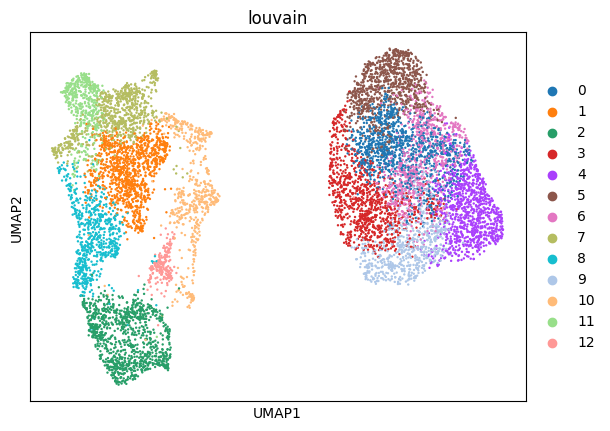

In [15]:
""" 9.UMAP: use it to visualice KNN.

-------------------------------------------------------------------------------------------------
allSo %<>% RunUMAP(dims = 1:20)
-------------------------------------------------------------------------------------------------
"""
# Embedding the neighborhood graph by running UMAP 
# UMAP to visualize clusters
umHVG_data = pcHVG_data.copy()
sc.tl.umap(umHVG_data,min_dist=0.3)
sc.pl.umap(umHVG_data, color='louvain')

### 10.Low quality clusters

Here, a vector named `badClu` is defined, which in this case is empty (`c()`). This vector is intended to contain the identifiers of the clusters that are considered to be of low quality and that should be removed from the analysis. However, since the vector is empty, no clusters will be removed in this step.

In [ ]:
""" 10.Delete low quality clusters

-----------------------------------------------------------------------------------------------------------------------------
badClu <- c() 
allSo <- allSo[, allSo$seurat_clusters %ni% badClu]
-----------------------------------------------------------------------------------------------------------------------------
"""


### More...

#### 1.UMAP + Leiden

/tmp/ipykernel_2462568/1550942787.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(umHVG_data, resolution=1)


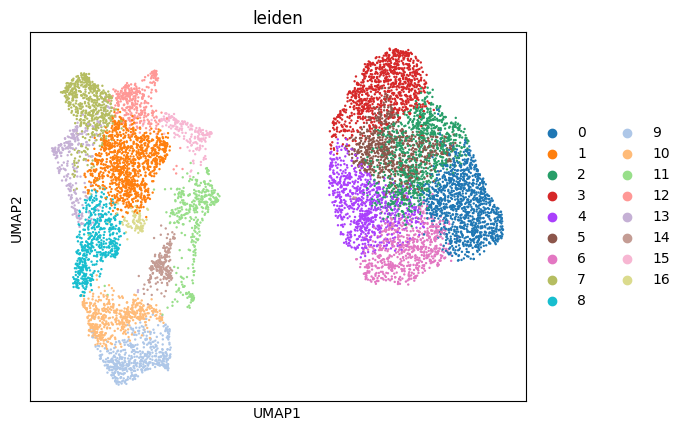

In [16]:
sc.tl.leiden(umHVG_data, resolution=1)
sc.pl.umap(umHVG_data, color="leiden")

#### 2.UMAP + Cell state

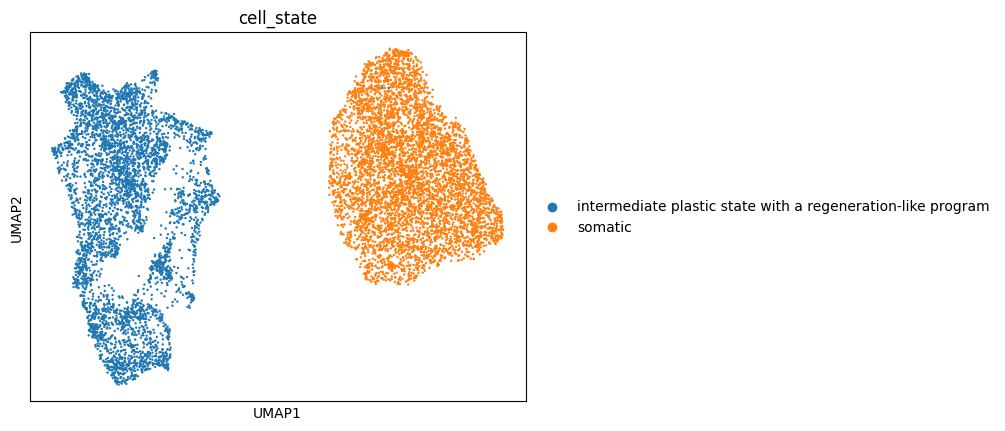

In [17]:
sc.pl.umap(umHVG_data, color="cell_state")